# Imports & paths

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from joblib import load

from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    roc_auc_score,
    average_precision_score,
)
from sklearn.metrics import roc_curve, precision_recall_curve

# Load dataset (augmented CSV) (using data/srna_augmented.csv created by fill_features_from_api.py)

In [2]:
DATA_PATH = Path("data/srna_augmented.csv")
MODEL_PATH = Path("models/interaction_rf.joblib")

df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()

(60, 18)


,organism,srna_name,mrna_name,srna_sequence,mrna_sequence,evidence_type,interaction_context,interaction_type_site,validation_level,reference_doi_or_pmid,notes,label_strength,deltaG_predicted,gc_content_srna,gc_content_mrna,seed_length,has_seed,hybrid_length
0,Escherichia coli,MicF,ompF,AUGCAGGUUCAUCAACACCUUAGGAAACCCUGCUUUGCACUCAUUG...,AGACACATAAAGACACCAAACUCUCAUCA,Toeprinting & Mutational Rescue,Envelope stressÃÂÃÂ¯ÃÂÃÂ¿ÃÂÃÂ½(high o...,RBS occlusionÃÂÃÂ¯ÃÂÃÂ¿ÃÂÃÂ½(direct b...,"HighÃÂÃÂ¯ÃÂÃÂ¿ÃÂÃÂ½(classic, well-map...","(Andersen et al., 1989;ÃÂÃÂ¯ÃÂÃÂ¿ÃÂÃÂ...",Classic porin switch regulator repressingÃÂÃ...,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,Escherichia coli,RyhB,sdhC,AUUGACUUUCAAAUGCGAGUCAAAUGCAUUUUUUUGCAAAAAGUGU...,GUUAUCAAAAUCGCCGGCGAGUCAUUAACGCC,Reporter Fusion & Northern Blot,Iron starvationÃÂÃÂ¯ÃÂÃÂ¿ÃÂÃÂ½(Fur re...,RBS occlusion & mRNA degradation,HighÃÂÃÂ¯ÃÂÃÂ¿ÃÂÃÂ½(biochemical & gen...,"(Masse & Gottesman, 2002;ÃÂÃÂ¯ÃÂÃÂ¿ÃÂÃ...",Core iron-sparing response: shuts down Fe-S cl...,1.0,-2.04,0.423729,0.500000,8.0,1.0,14.0
2,Escherichia coli,RyhB,sodB,Same as above,AAAGCACACCUGCUUCCUAUGAAAGUACUUUAAUCUGAUCAG,Western Blot & Toeprinting,Iron starvationÃÂÃÂ¯ÃÂÃÂ¿ÃÂÃÂ½(Fur re...,"Coding region pairing, RNase E-mediated decay",HighÃÂÃÂ¯ÃÂÃÂ¿ÃÂÃÂ½(direct pairing co...,"(Masse et al., 2003;ÃÂÃÂ¯ÃÂÃÂ¿ÃÂÃÂ½Mo...",Iron homeostasis: represses iron-containing su...,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,Escherichia coli,OmrA,csgD,GGCGCUUUUGGCAGAAAUUCACACCUUCCUGGUGCAGAUCAUCAGG...,AUUAAUAAUCCUAAUGAAAAUAACAAAAUGAA,Expression Array & Genetic Interaction,Envelope stress & biofilm regulationÃÂÃÂ¯Ã...,Translation inhibition via 5' UTR pairing,HighÃÂÃÂ¯ÃÂÃÂ¿ÃÂÃÂ½(validated by CLIP...,"(Holmqvist et al., 2010;ÃÂÃÂ¯ÃÂÃÂ¿ÃÂÃ...",Biofilm-metabolism switch: represses curli reg...,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,Escherichia coli,GcvB,oppA,UCCCUGCUGCCGGUUUGGUAAAGUGACCACCGACAGCACCCUUACC...,UGCAGGGGUGUAAUCUCAAGAAUGGCUUUUGCCUCCGC,Reporter Fusion & RIL-seq,Nutrient responseÃÂÃÂ¯ÃÂÃÂ¿ÃÂÃÂ½(Ntr ...,Seed pairing in G/U-rich region of 5' UTR,HighÃÂÃÂ¯ÃÂÃÂ¿ÃÂÃÂ½(RIL-seq validated),"(Sharma et al., 2007;ÃÂÃÂ¯ÃÂÃÂ¿ÃÂÃÂ½M...",Global nutrient regulator: targets multiple AB...,1.0,-8.29,0.516129,0.526316,0.0,0.0,24.0


# Clean & select feature columns

In [3]:
feature_cols = [
    "deltaG_predicted",
    "gc_content_srna",
    "gc_content_mrna",
    "seed_length",
    "has_seed",
    "hybrid_length",
]

target_col = "label_strength"

# Keep only rows with all needed values
df_clean = df.dropna(subset=feature_cols + [target_col]).copy()
df_clean.shape

(29, 18)

# Load model & build X / y

In [4]:
model = load(MODEL_PATH)

X = df_clean[feature_cols]
y = df_clean[target_col].astype(float)

X.head(), y.head()

(   deltaG_predicted  gc_content_srna  gc_content_mrna  seed_length  has_seed  \
 1             -2.04         0.423729         0.500000          8.0       1.0   
 4             -8.29         0.516129         0.526316          0.0       0.0   
 5             -4.46         0.418182         0.264151          6.0       1.0   
 7             -3.39         0.260870         0.333333          6.0       1.0   
 8            -11.66         0.515152         0.384615          6.0       1.0   
 
    hybrid_length  
 1           14.0  
 4           24.0  
 5           42.0  
 7           31.0  
 8           26.0  ,
 1    1.0
 4    1.0
 5    1.0
 7    1.0
 8    1.0
 Name: label_strength, dtype: float64)

# Predict with the RF model

In [5]:
y_pred = model.predict(X)

print("First 5 predictions:", y_pred[:5])

First 5 predictions: [0.969 0.964 0.994 0.987 0.979]


# Regression metrics

In [6]:
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y, y_pred)

print(f"R²        : {r2:.3f}")
print(f"RMSE      : {rmse:.3f}")
print(f"MAE       : {mae:.3f}")

R²        : 0.585
RMSE      : 0.123
MAE       : 0.087


# Scatter: true vs predicted label_strength

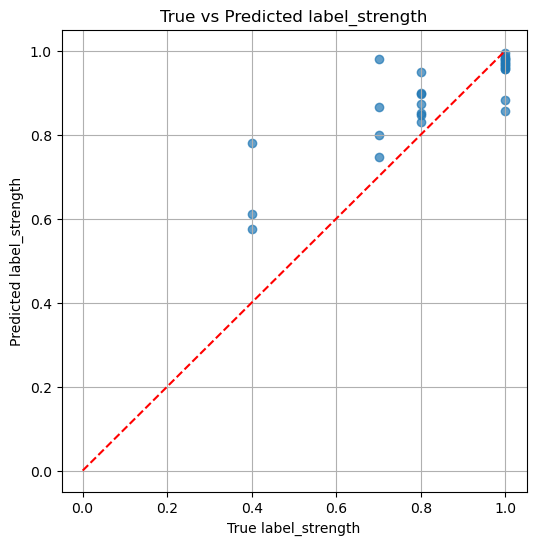

In [7]:
plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred, alpha=0.7)
plt.xlabel("True label_strength")
plt.ylabel("Predicted label_strength")
plt.title("True vs Predicted label_strength")
plt.plot([0, 1], [0, 1], "r--")
plt.grid(True)
plt.show()

# Convert to binary classes & compute ROC / PR

In [8]:
y_bin = (y >= 0.8).astype(int)

# Some models are regressors; we treat y_pred as "score"
scores = y_pred

roc_auc = roc_auc_score(y_bin, scores)
ap = average_precision_score(y_bin, scores)

print(f"ROC AUC            : {roc_auc:.3f}")
print(f"Average Precision  : {ap:.3f}")

ROC AUC            : 0.860
Average Precision  : 0.926


# ROC Curve

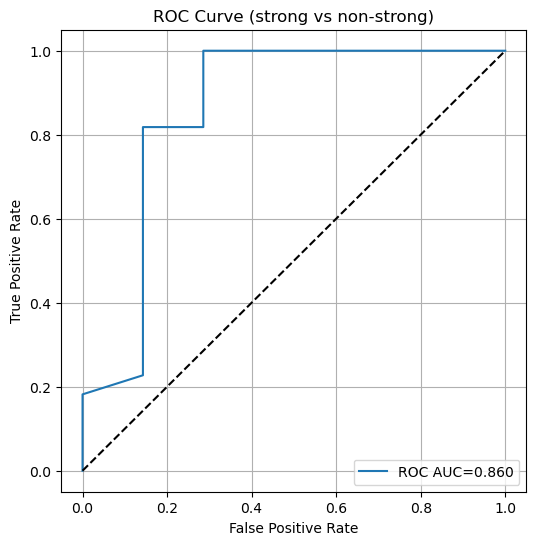

In [9]:
fpr, tpr, thr = roc_curve(y_bin, scores)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC AUC={roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (strong vs non-strong)")
plt.legend()
plt.grid(True)
plt.show()

# Precision–Recall curve

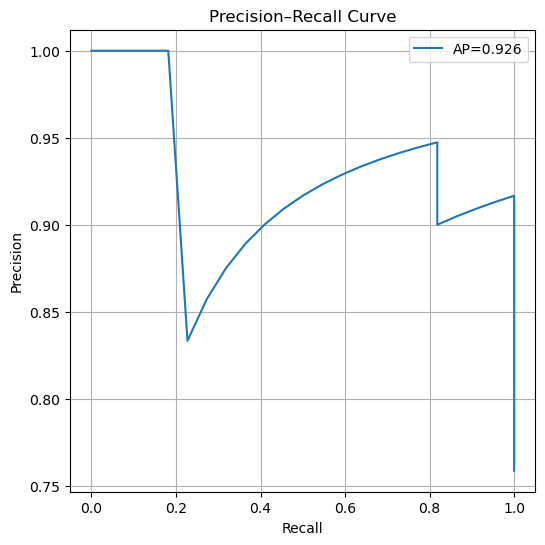

In [10]:
prec, rec, thr_pr = precision_recall_curve(y_bin, scores)

plt.figure(figsize=(6, 6))
plt.plot(rec, prec, label=f"AP={ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

df_clean.to_csv("../data/validation_input_used.csv", index=False)